<a href="https://colab.research.google.com/github/srujanreddy09/Mortgage-Default-Prediction-using-Deep-Learning/blob/main/FNMA_Multi_Home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Modules**

In [ ]:
!pip install tensorflow==2.0.0

In [2]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import random
RANDOM_SEED = 42
TRAINING_SAMPLE = 0.95
BATCH_SIZE = 64
LATENT_DIMENSION = 8

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy import sparse

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
tf.__version__

'2.0.0'

## **Loading the datasets**

# Choosing Fannie Mae Multifamily dataset to build a preliminary model.  

In [4]:
# Mounting the google drive where the data is present
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [5]:
# Choosing only relevant features. These can be adjusted
relevant_features = ["Loan Number",
                     "Note Date",
                     "Maturity Date - Current",
                     "Reporting Period Date",
                    "Loan Acquisition UPB", 
                     "UPB - Current",
                    "Amortization Type", 
                    "Interest Type", 
                    "Loan Product Type",
                    "Amortization Term", 
                    "Original Interest Rate", 
                    "Lien Position", 
                    "Loan Acquisition LTV",
                    "Underwritten DSCR",
                    "Underwritten DSCR Type",
                    "Original Term",
                    "Loan Ever 60+ Days Delinquent",
                    "SDQ Indicator",
                    "Number of Properties at Acquisition",
                    "Property Acquisition Total Unit Count",
                    "Specific Property Type",
                    "Property State",
                    "Physical Occupancy %",
                    "Loan Payment Status",
                    "Liquidation/Prepayment Code",
                    ]

In [6]:
# Path to the data directory
mf_data_path = root_dir + "FNMA/Multi_Family"
# Loading the csv into a dataframe
df = pd.read_csv(mf_data_path + "/FNMA_MF_Loan_Performance_Data_202003.csv", usecols = relevant_features)
# Choosing only the final status of the loans
df = df.loc[df["Liquidation/Prepayment Code"].notnull(), relevant_features]

## **Data Processing and Cleaning**

In [7]:
# Data Shape and Data Info
print(df.shape)
print(df.info())

(27895, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27895 entries, 3 to 3439320
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Loan Number                            27895 non-null  int64  
 1   Note Date                              27895 non-null  object 
 2   Maturity Date - Current                27895 non-null  object 
 3   Reporting Period Date                  27895 non-null  object 
 4   Loan Acquisition UPB                   27895 non-null  object 
 5   UPB - Current                          27895 non-null  object 
 6   Amortization Type                      27893 non-null  object 
 7   Interest Type                          27895 non-null  object 
 8   Loan Product Type                      27895 non-null  object 
 9   Amortization Term                      26868 non-null  float64
 10  Original Interest Rate                 27895 non-null  f

In [8]:
# Checking for missing data
print(df.isnull().sum())

Loan Number                                 0
Note Date                                   0
Maturity Date - Current                     0
Reporting Period Date                       0
Loan Acquisition UPB                        0
UPB - Current                               0
Amortization Type                           2
Interest Type                               0
Loan Product Type                           0
Amortization Term                        1027
Original Interest Rate                      0
Lien Position                               1
Loan Acquisition LTV                        3
Underwritten DSCR                           9
Underwritten DSCR Type                      9
Original Term                               0
Loan Ever 60+ Days Delinquent               0
SDQ Indicator                               0
Number of Properties at Acquisition       337
Property Acquisition Total Unit Count     543
Specific Property Type                      0
Property State                    

In [9]:
# Changing the data type of date features
df[["Note Date", "Maturity Date - Current", "Reporting Period Date"]] = df[["Note Date", "Maturity Date - Current", "Reporting Period Date"]].astype("datetime64")
# Creating a new delta column (Maturity date - Note Date)
df["Delta Maturity"] = (df["Maturity Date - Current"] - df["Note Date"]).apply(lambda x: x.days)
df.drop(columns=["Maturity Date - Current", "Note Date", "Reporting Period Date"], inplace = True)

In [10]:
# Cleaning the features corresponding to amount in USD 
df["Loan Acquisition UPB"] = df["Loan Acquisition UPB"].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')
df["UPB - Current"] = df["UPB - Current"].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')
# Creating a new delta column for Unpaid Principal Balance
df["Delta UPB"] = df["Loan Acquisition UPB"] - df["UPB - Current"]
df.drop(columns=["Loan Acquisition UPB", "UPB - Current"], inplace = True)

In [11]:
# Dropping NA values from categorical features. Missing data imputation can be explored further
df.dropna(subset=["Amortization Type", "Lien Position", "Underwritten DSCR Type"], inplace=True)

In [12]:
# Filling missing data of continous feature with either mean of mode
df["Amortization Term"].fillna(df["Amortization Term"].mode().iloc[0], inplace = True)
df["Number of Properties at Acquisition"].fillna(df["Number of Properties at Acquisition"].mode().iloc[0], inplace = True)
df["Loan Acquisition LTV"].fillna(df["Loan Acquisition LTV"].mean(), inplace = True)
df["Property Acquisition Total Unit Count"].fillna(df["Property Acquisition Total Unit Count"].mean(), inplace = True)
df["Physical Occupancy %"].fillna(100.0, inplace = True)

In [13]:
## Encoding the target variable
# 0 - Defaulted, 1 - Not Defaulted
df["Liquidation/Prepayment Code"].replace({
    "Deed-in-Lieu": 0,
    "Discounted Payoff": 1,
    "Dissolution": 1,
    "Foreclosure": 0,
    "Fully Paid, Matured": 1,
    "Fully Paid, Prepaid": 1,
    "Fully Paid, Refinanced": 1,
    "Repurchase": 1,
    "Substitution": 1,
    "Third Party Sale": 0,
    "Other Liquidation": 1
}, inplace = True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


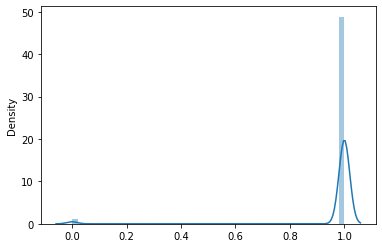

In [14]:
#Check if the data is imbalanced
sns.distplot(LabelEncoder().fit_transform(df["Liquidation/Prepayment Code"]))

In [15]:
df["Liquidation/Prepayment Code"].value_counts()

1    27221
0      664
Name: Liquidation/Prepayment Code, dtype: int64

## **EDA** ##

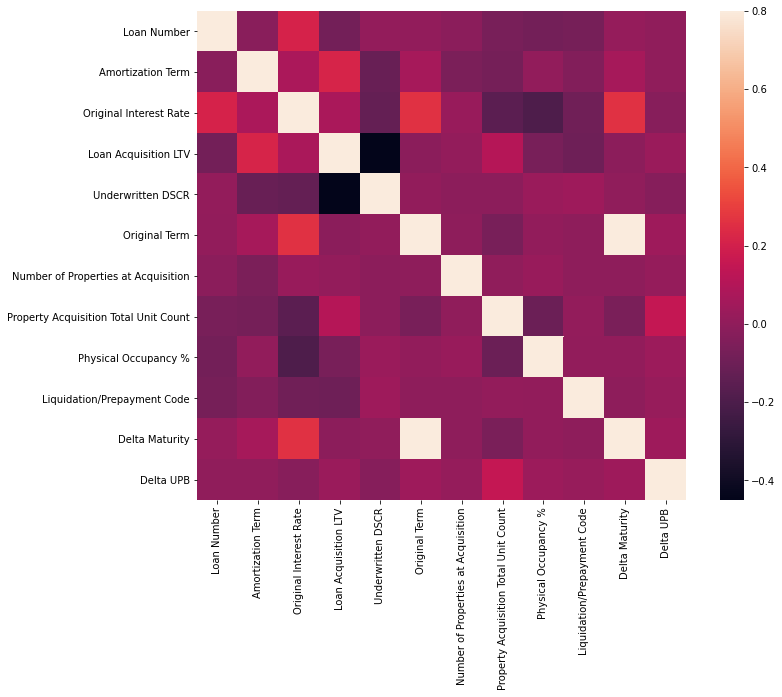

In [16]:
# Checking multicolinearity between continous features
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [17]:
## From the above heatmap, it is clear that original term and delta maturity have a high colinearity. Hence, dropping one of them.
df.drop(columns=["Delta Maturity"], inplace=True)

## **Preparing train and test splits**

In [18]:
## Split the data into closed and defaulted 
paid_df = df[df["Liquidation/Prepayment Code"] == 1]
default_df = df[df["Liquidation/Prepayment Code"] == 0]

In [19]:
## Split into train test
# Shuffle the dataset 
paid_df = paid_df.sample(frac=1).reset_index(drop=True)

train_size = int(len(paid_df)*TRAINING_SAMPLE)

train_df = paid_df.iloc[:train_size].drop("Liquidation/Prepayment Code", axis=1)
test_df_paid = paid_df.iloc[train_size:].sample(frac=1)
test_df_default = default_df.sample(frac=1)

In [20]:
test_df_paid["Liquidation/Prepayment Code"].value_counts()

1    1362
Name: Liquidation/Prepayment Code, dtype: int64

In [21]:
test_df_default["Liquidation/Prepayment Code"].value_counts()

0    664
Name: Liquidation/Prepayment Code, dtype: int64

In [22]:
test_df_paid.drop("Liquidation/Prepayment Code", axis=1, inplace=True)
test_df_default.drop("Liquidation/Prepayment Code", axis=1, inplace= True)

## **Encoding the Data**

In [23]:
categorical_variables = ["Amortization Type", "Interest Type", "Loan Product Type", "Lien Position", "Underwritten DSCR Type", "Loan Ever 60+ Days Delinquent", "SDQ Indicator", "Specific Property Type", "Property State", "Loan Payment Status"]
target_variable = ["Liquidation/Prepayment Code"]
numerical_variables = [feature for feature in df.columns if feature not in (categorical_variables + target_variable)]

In [24]:
#One hot encoding categorical variables
one_cat = OneHotEncoder(handle_unknown="ignore")
one_cat.fit(train_df[categorical_variables])

train_cat_variables_encoded = one_cat.transform(train_df[categorical_variables])
test_cat_paid = one_cat.transform(test_df_paid[categorical_variables])
test_cat_default = one_cat.transform(test_df_default[categorical_variables])

In [25]:
# Standardizing numerical features
sc_num = StandardScaler()
sc_num.fit(train_df[numerical_variables])

train_num_variables_encoded = sc_num.transform(train_df[numerical_variables])
test_num_paid = sc_num.transform(test_df_paid[numerical_variables])
test_num_default = sc_num.transform(test_df_default[numerical_variables])

## **Autoencoder**

In [26]:
# Create Input
train_input = sparse.hstack((train_cat_variables_encoded, train_num_variables_encoded)).toarray()
input_shape = train_input.shape

In [27]:
# Model
autoencoder = tf.keras.models.Sequential()
# Encoding Layers
autoencoder.add(tf.keras.layers.Dense(input_shape[1], activation="relu", input_shape = (input_shape[1], )))
autoencoder.add(tf.keras.layers.GaussianNoise(0.05))
autoencoder.add(tf.keras.layers.Dense(32, activation="relu"))
# Compressed representation
autoencoder.add(tf.keras.layers.Dense(LATENT_DIMENSION, activation="relu"))
# Decoding layers
autoencoder.add(tf.keras.layers.Dense(32, activation="relu"))
autoencoder.add(tf.keras.layers.Dense(input_shape[1], activation="relu"))

# Compiling Model
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(), loss = "mae", metrics = ["mae"])

In [28]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 99)                9900      
_________________________________________________________________
gaussian_noise (GaussianNois (None, 99)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3200      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_4 (Dense)              (None, 99)                3267      
Total params: 16,919
Trainable params: 16,919
Non-trainable params: 0
____________________________________________________

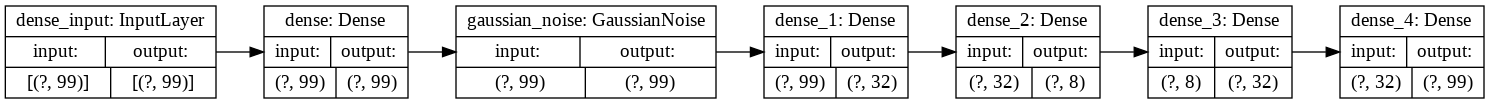

In [29]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_names=True, rankdir = "LR")

In [30]:
callback=[tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)]

In [31]:
history = autoencoder.fit(train_input, train_input, epochs = 100, batch_size = BATCH_SIZE, callbacks=callback, validation_split=0.2)

Train on 20687 samples, validate on 5172 samples
Epoch 1/100
20687/20687 [==============================] - 3s 124us/sample - loss: 0.1084 - mae: 0.1084 - val_loss: 0.0814 - val_mae: 0.0814
Epoch 2/100
20687/20687 [==============================] - 1s 71us/sample - loss: 0.0790 - mae: 0.0790 - val_loss: 0.0757 - val_mae: 0.0757
Epoch 3/100
20687/20687 [==============================] - 1s 71us/sample - loss: 0.0752 - mae: 0.0752 - val_loss: 0.0753 - val_mae: 0.0753
Epoch 4/100
20687/20687 [==============================] - 2s 76us/sample - loss: 0.0745 - mae: 0.0745 - val_loss: 0.0732 - val_mae: 0.0732
Epoch 5/100
20687/20687 [==============================] - 1s 71us/sample - loss: 0.0724 - mae: 0.0724 - val_loss: 0.0720 - val_mae: 0.0720
Epoch 6/100
20687/20687 [==============================] - 1s 69us/sample - loss: 0.0716 - mae: 0.0716 - val_loss: 0.0717 - val_mae: 0.0717
Epoch 7/100
20687/20687 [==============================] - 1s 71us/sample - loss: 0.0713 - mae: 0.0713 - val_l

## **Reconstructing Test Data**

In [32]:
test_input_paid = sparse.hstack((test_cat_paid, test_num_paid)).toarray()
reconstructions_paid = autoencoder.predict(test_input_paid)

test_input_default = sparse.hstack((test_cat_default, test_num_default)).toarray()
reconstructions_default = autoencoder.predict(test_input_default)

In [33]:
mae_paid = np.mean(np.abs(test_input_paid - reconstructions_paid), axis=1)
mae_default = np.mean(np.abs(test_input_default - reconstructions_default), axis=1)

In [34]:
mae_paid.mean()

0.06436724424654929

In [35]:
mae_default.mean()

0.10563797903040247

# Future Plan of Action
Determine Thresholds

Scale this model to larger dataset(Single Family mortgages). Will increase the imbalance which will improve the autoencoder

Incorporate external macroeconomic factors

Try other architecutres

HyperParameter Tuning, Feature Engineering
